Epoch [10000/10000], Loss D: 0.6931, Loss G: 0.6955


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

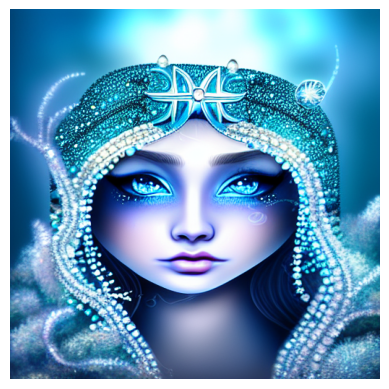

Generator(
  (latent_fc): Linear(in_features=128, out_features=16384, bias=True)
  (feature_fc): Linear(in_features=10, out_features=16384, bias=True)
  (main): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import cv2

# ============ 1️⃣ Load and Preprocess Image ============
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to fixed size
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_and_preprocess_image(image_path):
    """Load an image and extract edges using Canny."""
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))

    # Convert to grayscale and detect edges
    image_np = np.array(image)
    edges = cv2.Canny(image_np, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL format
    edge_image = Image.fromarray(edges)
    return image, edge_image

image_path = "/kaggle/input/girlone/girl1.PNG"  # Change this to your image path
image_tensor = load_image(image_path)
input_image, control_image = load_and_preprocess_image(image_path)

# ============ 2️⃣ Define Generator with Feature Vector ============
class Generator(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, feature_dim=10):
        super(Generator, self).__init__()
        
        self.latent_fc = nn.Linear(latent_dim, 128 * 128)  # Latent vector to image size
        self.feature_fc = nn.Linear(feature_dim, 128 * 128)  # Feature vector processing
        
        self.main = nn.Sequential(
            nn.Conv2d(input_channels + 2, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x, latent_vector, feature_vector):
        latent_map = self.latent_fc(latent_vector).view(1, 1, 128, 128)
        feature_map = self.feature_fc(feature_vector).view(1, 1, 128, 128)
        
        # Concatenate input image, latent vector map, and feature map
        x = torch.cat((x, latent_map, feature_map), dim=1)
        return self.main(x)

# ============ 3️⃣ Define Discriminator ============
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# ============ 4️⃣ Training Loop with Stable Diffusion Image Generation ============
def train_singan_with_image_generation(image_tensor, num_epochs=10000, lr=0.0002):
    generator.train()
    discriminator.train()
    
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=3000, gamma=0.5)
    scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=3000, gamma=0.5)
    
    real_label = torch.ones(1, 1, 128, 128).to(device)
    fake_label = torch.zeros(1, 1, 128, 128).to(device)
    
    image_tensor = image_tensor.to(device)

    for epoch in range(num_epochs):
        # Generate random latent vector and feature vector
        latent_vector = torch.randn(1, 128).to(device)
        feature_vector = torch.randint(0, 2, (1, 10)).float().to(device)  # Random binary features
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        output_real = discriminator(image_tensor)
        loss_real = criterion(output_real, real_label)
        
        fake_image = generator(image_tensor, latent_vector, feature_vector)
        output_fake = discriminator(fake_image.detach())
        loss_fake = criterion(output_fake, fake_label)
        
        loss_d = (loss_real + loss_fake) / 2
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        output_fake = discriminator(fake_image)
        loss_g = criterion(output_fake, real_label)
        loss_g.backward()
        optimizer_g.step()

        scheduler_g.step()
        scheduler_d.step()

        # Generate and display an image only during the final epoch
        if epoch + 1 == num_epochs:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
            
            # Generate Modified Image using Stable Diffusion + ControlNet
            controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=torch.float16)
            pipe = StableDiffusionControlNetPipeline.from_pretrained(
                "runwayml/stable-diffusion-v1-5",
                controlnet=controlnet,
                torch_dtype=torch.float16
            )
            pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
            pipe.to(device)

            # Updated scary horror prompt
            prompt = "A beautiful lady with crystal in her ocean-blue eyes, ultra-detailed, digital painting, cinematic depth, realistic textures, fantasy lighting, high-quality character portrait"
            negative_prompt = "blurry, low quality, bad anatomy, distorted face, extra limbs, unrealistic proportions"

            generated_image = pipe(
                prompt=prompt,
                image=control_image,  # Use edge-detected image as control input
                negative_prompt=negative_prompt,
                num_inference_steps=80,  # Increased steps for better quality
                guidance_scale=12,  # Stronger prompt adherence
                num_images_per_prompt=1  # Ensure only 1 image is generated
            ).images[0]

            # Display Generated Image
            plt.imshow(generated_image)
            plt.axis("off")  # Hide axes
            plt.show()

    return generator

# Start training the GAN and generate Stable Diffusion image only during the final epoch
train_singan_with_image_generation(image_tensor)


Epoch 1/1500 | D: 1.4043 | G: 0.6893 | P_obj: -0.6587
Epoch 100/1500 | D: 1.3597 | G: 0.8743
Epoch 200/1500 | D: 1.3867 | G: 0.6567
Epoch 300/1500 | D: 1.3825 | G: 0.7966
Epoch 400/1500 | D: 1.4001 | G: 0.6687 | P_obj: -0.6702
Epoch 500/1500 | D: 1.3693 | G: 0.6542
Epoch 600/1500 | D: 1.3790 | G: 0.7355
Epoch 700/1500 | D: 1.3849 | G: 0.6444
Epoch 800/1500 | D: 0.8191 | G: 0.7948
Epoch 900/1500 | D: 1.3954 | G: 0.6820
Epoch 1000/1500 | D: 1.4198 | G: 0.7161 | P_obj: -0.7352
Epoch 1100/1500 | D: 1.3904 | G: 0.6527
Epoch 1200/1500 | D: 1.3747 | G: 0.6741
Epoch 1300/1500 | D: 1.3940 | G: 0.6846
Epoch 1400/1500 | D: 1.3864 | G: 0.6417 | P_obj: -0.6362
Epoch 1500/1500 | D: 1.4020 | G: 0.7137 | P_obj: -0.7247


2025-08-28 13:46:48.252959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756388808.624540      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756388808.729833      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

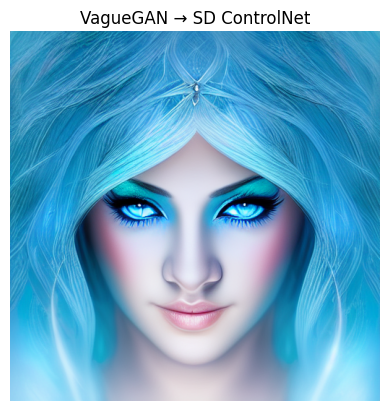


[Spectral Signature Report]
Samples: 1500 | Poison rate: 0.285
Precision: 0.300 | Recall: 0.105 | F1: 0.156

Backdoor Success (proxy intensity lift): 0.0236


In [1]:
# vaguegan_full_thesis.py
import os, random, numpy as np
from typing import Tuple, List
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import precision_recall_fscore_support

# ------------------------
# 1) Data loaders
# ------------------------
def load_image(image_path: str, size: Tuple[int,int]=(128,128)) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def load_softedge_control_image(image_path: str, size: Tuple[int,int]=(512,512)):
    image = Image.open(image_path).convert("RGB").resize(size)
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    edges = np.uint8(np.absolute(edges))
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edge_image = Image.fromarray(edges_rgb)
    return image, edge_image

# ------------------------
# 2) VagueGAN Poisoner
# ------------------------
class PoisonerNet(nn.Module):
    def __init__(self, in_channels=3, z_dim=32, hidden=64):
        super().__init__()
        self.z_proj = nn.Sequential(nn.Linear(z_dim,16*16), nn.ReLU(True))
        self.upsample = nn.Upsample(size=(128,128), mode='bilinear', align_corners=False)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels+1, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, in_channels,3,1,1), nn.Tanh()
        )
    def forward(self,x,z):
        N,_,H,W = x.shape
        z_map = self.z_proj(z).view(N,1,16,16)
        z_map = self.upsample(z_map)
        return self.net(torch.cat([x,z_map],dim=1))

def project_linf(x, eps):
    return torch.clamp(x, -eps, eps)

def total_variation(x):
    return ((x[:,:,1:,:]-x[:,:,:-1,:]).abs().mean() +
            (x[:,:,:,1:]-x[:,:,:,:-1]).abs().mean())

def laplacian_abs_mean(x):
    kernel = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    x_gray = x.mean(dim=1,keepdim=True)
    lap = torch.nn.functional.conv2d(x_gray, kernel, padding=1)
    return lap.abs().mean()

# ------------------------
# 3) GAN Models
# ------------------------
class Generator(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, feature_dim=10):
        super().__init__()
        self.latent_fc = nn.Linear(latent_dim, 128*128)
        self.feature_fc = nn.Linear(feature_dim, 128*128)
        self.main = nn.Sequential(
            nn.Conv2d(input_channels+2,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(True),
            nn.Conv2d(128,256,3,1,1), nn.ReLU(True),
            nn.Conv2d(256,128,3,1,1), nn.ReLU(True),
            nn.Conv2d(128,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,3,3,1,1), nn.Tanh()
        )
    def forward(self, x, latent_vector, feature_vector):
        N = x.size(0)
        latent_map = self.latent_fc(latent_vector).view(N,1,128,128)
        feature_map = self.feature_fc(feature_vector).view(N,1,128,128)
        x = torch.cat([x,latent_map,feature_map],dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self,input_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,64,3,1,1)
        self.act1 = nn.LeakyReLU(0.2,inplace=True)
        self.conv2 = nn.Conv2d(64,128,3,1,1)
        self.act2 = nn.LeakyReLU(0.2,inplace=True)
        self.conv3 = nn.Conv2d(128,1,3,1,1)
        self.out_act = nn.Sigmoid()
        self.gap = nn.AdaptiveAvgPool2d((1,1))
    def forward(self,x,return_features:bool=True):
        h = self.act1(self.conv1(x))
        h = self.act2(self.conv2(h))
        logits = self.conv3(h)
        out = self.out_act(logits)
        if return_features:
            feat = self.gap(h).view(x.size(0),-1)
            return out, feat
        return out

# ------------------------
# 4) Backdoor proxy
# ------------------------
@torch.no_grad()
def backdoor_success_proxy(G: nn.Module, base_input: torch.Tensor, eps: float, trials:int=5) -> float:
    device = next(G.parameters()).device
    base_input = base_input.to(device)
    diffs = []
    N,C,H,W = base_input.shape
    size = 10
    r0 = H-8-size; c0=W-8-size
    r_s = slice(max(r0,0), max(r0,0)+size)
    c_s = slice(max(c0,0), max(c0,0)+size)
    for _ in range(trials):
        z = torch.randn(N,128,device=device)
        f = torch.randint(0,2,(N,10),device=device,dtype=torch.float)
        y_clean = G(base_input,z,f).detach().cpu()
        x_trig = base_input.clone()
        x_trig[:,:,r_s,c_s] = torch.clamp(x_trig[:,:,r_s,c_s]+eps,-1,1)
        y_trig = G(x_trig,z,f).detach().cpu()
        rc = ((y_clean[:,:,r_s,c_s]+1)/2).mean().item()
        rt = ((y_trig[:,:,r_s,c_s]+1)/2).mean().item()
        diffs.append(rt-rc)
    return float(np.mean(diffs))

# ------------------------
# 5) Training loop
# ------------------------
def train_vaguegan(
    image_path: str,
    num_epochs: int = 1500,
    lr: float = 2e-4,
    poison_rate: float = 0.3,
    eps: float = 0.08,      # increased
    z_dim_poison: int = 32,
    lambda_stealth: float = 5e-2,
    lambda_tv: float = 1e-2,
    lambda_hf: float = 1e-2, # increased
    feature_collect_limit: int = 2000,
    print_every: int = 100,
    use_stable_diffusion: bool = True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G,D,P = Generator().to(device), Discriminator().to(device), PoisonerNet(z_dim=z_dim_poison).to(device)
    x0 = load_image(image_path).to(device)
    _, softedge_512 = load_softedge_control_image(image_path)
    criterion = nn.BCELoss()
    opt_g = optim.Adam(G.parameters(),lr=lr,betas=(0.5,0.999))
    opt_d = optim.Adam(D.parameters(),lr=lr,betas=(0.5,0.999))
    opt_p = optim.Adam(P.parameters(),lr=lr,betas=(0.5,0.999))
    real_label = torch.ones(1,1,128,128,device=device)
    fake_label = torch.zeros(1,1,128,128,device=device)
    feat_bank, poison_flags = [], []

    for epoch in range(1,num_epochs+1):
        use_poison = random.random()<poison_rate
        x_real = x0
        if use_poison:
            z_p = torch.randn(1,z_dim_poison,device=device)
            delta = project_linf(P(x0,z_p)*eps, eps)
            x_real = torch.clamp(x0+delta, -1,1)

        x_real_det = x_real.detach()
        # --- D update
        opt_d.zero_grad()
        out_real, feat_real = D(x_real,return_features=True)
        loss_real = criterion(out_real, real_label)
        if len(feat_bank)<feature_collect_limit:
            feat_bank.append(feat_real.detach().cpu().numpy().squeeze(0))
            poison_flags.append(1 if use_poison else 0)
        z = torch.randn(1,128,device=device)
        f = torch.randint(0,2,(1,10),device=device,dtype=torch.float)
        x_fake_d = G(x_real_det,z,f).detach()
        out_fake = D(x_fake_d,return_features=False)
        loss_fake = criterion(out_fake, fake_label)
        (0.5*(loss_real+loss_fake)).backward()
        opt_d.step()

        # --- G update
        opt_g.zero_grad()
        z2 = torch.randn(1,128,device=device)
        f2 = torch.randint(0,2,(1,10),device=device,dtype=torch.float)
        x_fake_g = G(x_real_det,z2,f2)
        out_fake_for_g = D(x_fake_g,return_features=False)
        loss_g = criterion(out_fake_for_g, real_label)
        loss_g.backward()
        opt_g.step()

        # --- Poisoner update
        if use_poison:
            opt_p.zero_grad()
            z_p = torch.randn(1,z_dim_poison,device=device)
            delta = project_linf(P(x0,z_p)*eps,eps)
            x_poison = torch.clamp(x0+delta,-1,1)
            out_real_p,_ = D(x_poison,return_features=True)
            mse_stealth = torch.mean((x_poison-x0)**2)
            tv = total_variation(delta)
            hf = laplacian_abs_mean(delta)
            poison_obj = (-criterion(out_real_p, real_label)
                          + lambda_stealth*mse_stealth
                          + lambda_tv*tv
                          - lambda_hf*hf)
            poison_obj.backward()
            opt_p.step()

        if epoch%print_every==0 or epoch==1:
            msg = f"Epoch {epoch}/{num_epochs} | D: {loss_real.item()+loss_fake.item():.4f} | G: {loss_g.item():.4f}"
            if use_poison:
                msg += f" | P_obj: {poison_obj.item():.4f}"
            print(msg)

        # --- Optional SD+ControlNet
        if epoch==num_epochs and use_stable_diffusion:
            try:
                from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
                controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=torch.float16)
                pipe = StableDiffusionControlNetPipeline.from_pretrained(
                    "runwayml/stable-diffusion-v1-5",
                    controlnet=controlnet,
                    torch_dtype=torch.float16
                )
                pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
                pipe.to(device)
                prompt = "A beautiful lady with crystal in her ocean-blue eyes , ultra-detailed, digital painting, cinematic depth, realistic textures, fantasy lighting, high-quality character portrait"
                negative_prompt = "blurry, low quality, bad anatomy, distorted face, extra limbs, unrealistic proportions"
                gen_image = pipe(prompt=prompt, image=softedge_512, negative_prompt=negative_prompt,
                                num_inference_steps=60, guidance_scale=10, num_images_per_prompt=1).images[0]
                plt.imshow(gen_image); plt.axis("off"); plt.title("VagueGAN → SD ControlNet"); plt.show()
            except Exception as e:
                print(f"[WARN] Stable Diffusion skipped: {e}")

    # --- Spectral signature analysis
    F = np.vstack(feat_bank)
    y = np.array(poison_flags)
    F_center = F-F.mean(axis=0,keepdims=True)
    U,S,Vt = np.linalg.svd(F_center,full_matrices=False)
    v1 = Vt[0]
    scores = np.abs(F_center @ v1)
    thresh = np.percentile(scores,90.0)
    pred = (scores>=thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y,pred,average='binary',zero_division=0)
    print("\n[Spectral Signature Report]")
    print(f"Samples: {len(y)} | Poison rate: {y.mean():.3f}")
    print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    basr = backdoor_success_proxy(G,x0,eps=eps)
    print(f"\nBackdoor Success (proxy intensity lift): {basr:.4f}")

    return G,P

# ------------------------
# 6) Run
# ------------------------
if __name__=="__main__":
    IMAGE_PATH = "/kaggle/input/girlone/girl1.PNG"
    G_model, P_model = train_vaguegan(
        image_path=IMAGE_PATH,
        num_epochs=1500,
        lr=2e-4,
        poison_rate=0.3,
        eps=0.08,
        lambda_hf=1e-2,
        feature_collect_limit=2000,
        print_every=100,
        use_stable_diffusion=True
    )


2025-09-28 09:50:48.971336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759053049.312001      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759053049.408238      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch [10000/10000], Loss D: 0.6931, Loss G: 0.6945


config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

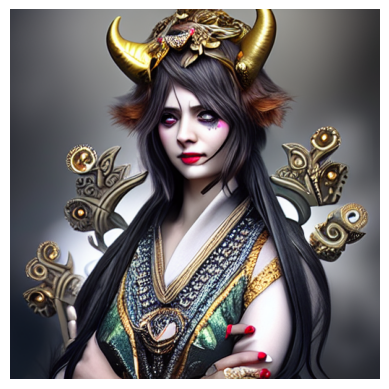

Generator(
  (latent_fc): Linear(in_features=128, out_features=16384, bias=True)
  (feature_fc): Linear(in_features=10, out_features=16384, bias=True)
  (main): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import cv2

# ============ 1️⃣ Load and Preprocess Image ============
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to fixed size
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_and_preprocess_image(image_path):
    """Load an image and extract edges using Canny."""
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))

    # Convert to grayscale and detect edges
    image_np = np.array(image)
    edges = cv2.Canny(image_np, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL format
    edge_image = Image.fromarray(edges)
    return image, edge_image

image_path = "/kaggle/input/fairyyy/fairy.jpg"  # Change this to your image path
image_tensor = load_image(image_path)
input_image, control_image = load_and_preprocess_image(image_path)

# ============ 2️⃣ Define Generator with Feature Vector ============
class Generator(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, feature_dim=10):
        super(Generator, self).__init__()
        
        self.latent_fc = nn.Linear(latent_dim, 128 * 128)  # Latent vector to image size
        self.feature_fc = nn.Linear(feature_dim, 128 * 128)  # Feature vector processing
        
        self.main = nn.Sequential(
            nn.Conv2d(input_channels + 2, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x, latent_vector, feature_vector):
        latent_map = self.latent_fc(latent_vector).view(1, 1, 128, 128)
        feature_map = self.feature_fc(feature_vector).view(1, 1, 128, 128)
        
        # Concatenate input image, latent vector map, and feature map
        x = torch.cat((x, latent_map, feature_map), dim=1)
        return self.main(x)

# ============ 3️⃣ Define Discriminator ============
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# ============ 4️⃣ Training Loop with Stable Diffusion Image Generation ============
def train_singan_with_image_generation(image_tensor, num_epochs=10000, lr=0.0002):
    generator.train()
    discriminator.train()
    
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=3000, gamma=0.5)
    scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=3000, gamma=0.5)
    
    real_label = torch.ones(1, 1, 128, 128).to(device)
    fake_label = torch.zeros(1, 1, 128, 128).to(device)
    
    image_tensor = image_tensor.to(device)

    for epoch in range(num_epochs):
        # Generate random latent vector and feature vector
        latent_vector = torch.randn(1, 128).to(device)
        feature_vector = torch.randint(0, 2, (1, 10)).float().to(device)  # Random binary features
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        output_real = discriminator(image_tensor)
        loss_real = criterion(output_real, real_label)
        
        fake_image = generator(image_tensor, latent_vector, feature_vector)
        output_fake = discriminator(fake_image.detach())
        loss_fake = criterion(output_fake, fake_label)
        
        loss_d = (loss_real + loss_fake) / 2
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        output_fake = discriminator(fake_image)
        loss_g = criterion(output_fake, real_label)
        loss_g.backward()
        optimizer_g.step()

        scheduler_g.step()
        scheduler_d.step()

        # Generate and display an image only during the final epoch
        if epoch + 1 == num_epochs:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
            
            # Generate Modified Image using Stable Diffusion + ControlNet
            controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=torch.float16)
            pipe = StableDiffusionControlNetPipeline.from_pretrained(
                "runwayml/stable-diffusion-v1-5",
                controlnet=controlnet,
                torch_dtype=torch.float16
            )
            pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
            pipe.to(device)

            # Updated scary horror prompt
            prompt = "A mistry lady with horns, smlling, ultra-detailed, digital painting, cinematic depth, realistic textures, fantasy lighting, high-quality character portrait"
            negative_prompt = "blurry, low quality, bad anatomy, distorted face, extra limbs, unrealistic proportions"

            generated_image = pipe(
                prompt=prompt,
                image=control_image,  # Use edge-detected image as control input
                negative_prompt=negative_prompt,
                num_inference_steps=80,  # Increased steps for better quality
                guidance_scale=12,  # Stronger prompt adherence
                num_images_per_prompt=1  # Ensure only 1 image is generated
            ).images[0]

            # Display Generated Image
            plt.imshow(generated_image)
            plt.axis("off")  # Hide axes
            plt.show()

    return generator

# Start training the GAN and generate Stable Diffusion image only during the final epoch
train_singan_with_image_generation(image_tensor)


Epoch 1/1500 | D: 1.3473 | G: 0.6758
Epoch 100/1500 | D: 1.4907 | G: 0.6674 | P_obj: -0.7548
Epoch 200/1500 | D: 1.3910 | G: 0.6596 | P_obj: -0.6093
Epoch 300/1500 | D: 1.3809 | G: 0.6841
Epoch 400/1500 | D: 1.3864 | G: 0.6908 | P_obj: -0.6878
Epoch 500/1500 | D: 1.3716 | G: 0.7761
Epoch 600/1500 | D: 1.3911 | G: 0.6935
Epoch 700/1500 | D: 1.3539 | G: 0.8268
Epoch 800/1500 | D: 1.3791 | G: 0.7530
Epoch 900/1500 | D: 1.3775 | G: 0.7289 | P_obj: -0.7174
Epoch 1000/1500 | D: 1.3853 | G: 0.7246
Epoch 1100/1500 | D: 1.3937 | G: 0.7084
Epoch 1200/1500 | D: 1.3829 | G: 0.7463
Epoch 1300/1500 | D: 1.3746 | G: 0.7503
Epoch 1400/1500 | D: 1.3860 | G: 0.7088
Epoch 1500/1500 | D: 1.3836 | G: 0.7260


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

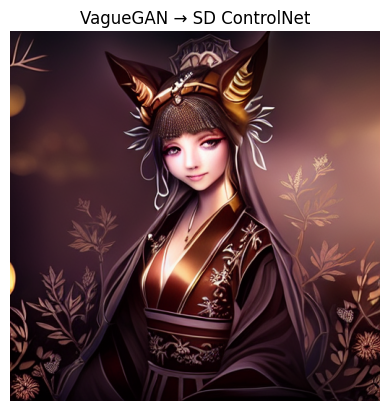


[Spectral Signature Report]
Samples: 1500 | Poison rate: 0.288
Precision: 0.293 | Recall: 0.102 | F1: 0.151

Backdoor Success (proxy intensity lift): 0.0121


In [3]:
# vaguegan_full_thesis.py
import os, random, numpy as np
from typing import Tuple, List
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import precision_recall_fscore_support

# ------------------------
# 1) Data loaders
# ------------------------
def load_image(image_path: str, size: Tuple[int,int]=(128,128)) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def load_softedge_control_image(image_path: str, size: Tuple[int,int]=(512,512)):
    image = Image.open(image_path).convert("RGB").resize(size)
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    edges = np.uint8(np.absolute(edges))
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edge_image = Image.fromarray(edges_rgb)
    return image, edge_image

# ------------------------
# 2) VagueGAN Poisoner
# ------------------------
class PoisonerNet(nn.Module):
    def __init__(self, in_channels=3, z_dim=32, hidden=64):
        super().__init__()
        self.z_proj = nn.Sequential(nn.Linear(z_dim,16*16), nn.ReLU(True))
        self.upsample = nn.Upsample(size=(128,128), mode='bilinear', align_corners=False)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels+1, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, in_channels,3,1,1), nn.Tanh()
        )
    def forward(self,x,z):
        N,_,H,W = x.shape
        z_map = self.z_proj(z).view(N,1,16,16)
        z_map = self.upsample(z_map)
        return self.net(torch.cat([x,z_map],dim=1))

def project_linf(x, eps):
    return torch.clamp(x, -eps, eps)

def total_variation(x):
    return ((x[:,:,1:,:]-x[:,:,:-1,:]).abs().mean() +
            (x[:,:,:,1:]-x[:,:,:,:-1]).abs().mean())

def laplacian_abs_mean(x):
    kernel = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    x_gray = x.mean(dim=1,keepdim=True)
    lap = torch.nn.functional.conv2d(x_gray, kernel, padding=1)
    return lap.abs().mean()

# ------------------------
# 3) GAN Models
# ------------------------
class Generator(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, feature_dim=10):
        super().__init__()
        self.latent_fc = nn.Linear(latent_dim, 128*128)
        self.feature_fc = nn.Linear(feature_dim, 128*128)
        self.main = nn.Sequential(
            nn.Conv2d(input_channels+2,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(True),
            nn.Conv2d(128,256,3,1,1), nn.ReLU(True),
            nn.Conv2d(256,128,3,1,1), nn.ReLU(True),
            nn.Conv2d(128,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,3,3,1,1), nn.Tanh()
        )
    def forward(self, x, latent_vector, feature_vector):
        N = x.size(0)
        latent_map = self.latent_fc(latent_vector).view(N,1,128,128)
        feature_map = self.feature_fc(feature_vector).view(N,1,128,128)
        x = torch.cat([x,latent_map,feature_map],dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self,input_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,64,3,1,1)
        self.act1 = nn.LeakyReLU(0.2,inplace=True)
        self.conv2 = nn.Conv2d(64,128,3,1,1)
        self.act2 = nn.LeakyReLU(0.2,inplace=True)
        self.conv3 = nn.Conv2d(128,1,3,1,1)
        self.out_act = nn.Sigmoid()
        self.gap = nn.AdaptiveAvgPool2d((1,1))
    def forward(self,x,return_features:bool=True):
        h = self.act1(self.conv1(x))
        h = self.act2(self.conv2(h))
        logits = self.conv3(h)
        out = self.out_act(logits)
        if return_features:
            feat = self.gap(h).view(x.size(0),-1)
            return out, feat
        return out

# ------------------------
# 4) Backdoor proxy
# ------------------------
@torch.no_grad()
def backdoor_success_proxy(G: nn.Module, base_input: torch.Tensor, eps: float, trials:int=5) -> float:
    device = next(G.parameters()).device
    base_input = base_input.to(device)
    diffs = []
    N,C,H,W = base_input.shape
    size = 10
    r0 = H-8-size; c0=W-8-size
    r_s = slice(max(r0,0), max(r0,0)+size)
    c_s = slice(max(c0,0), max(c0,0)+size)
    for _ in range(trials):
        z = torch.randn(N,128,device=device)
        f = torch.randint(0,2,(N,10),device=device,dtype=torch.float)
        y_clean = G(base_input,z,f).detach().cpu()
        x_trig = base_input.clone()
        x_trig[:,:,r_s,c_s] = torch.clamp(x_trig[:,:,r_s,c_s]+eps,-1,1)
        y_trig = G(x_trig,z,f).detach().cpu()
        rc = ((y_clean[:,:,r_s,c_s]+1)/2).mean().item()
        rt = ((y_trig[:,:,r_s,c_s]+1)/2).mean().item()
        diffs.append(rt-rc)
    return float(np.mean(diffs))

# ------------------------
# 5) Training loop
# ------------------------
def train_vaguegan(
    image_path: str,
    num_epochs: int = 1500,
    lr: float = 2e-4,
    poison_rate: float = 0.3,
    eps: float = 0.08,      # increased
    z_dim_poison: int = 32,
    lambda_stealth: float = 5e-2,
    lambda_tv: float = 1e-2,
    lambda_hf: float = 1e-2, # increased
    feature_collect_limit: int = 2000,
    print_every: int = 100,
    use_stable_diffusion: bool = True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G,D,P = Generator().to(device), Discriminator().to(device), PoisonerNet(z_dim=z_dim_poison).to(device)
    x0 = load_image(image_path).to(device)
    _, softedge_512 = load_softedge_control_image(image_path)
    criterion = nn.BCELoss()
    opt_g = optim.Adam(G.parameters(),lr=lr,betas=(0.5,0.999))
    opt_d = optim.Adam(D.parameters(),lr=lr,betas=(0.5,0.999))
    opt_p = optim.Adam(P.parameters(),lr=lr,betas=(0.5,0.999))
    real_label = torch.ones(1,1,128,128,device=device)
    fake_label = torch.zeros(1,1,128,128,device=device)
    feat_bank, poison_flags = [], []

    for epoch in range(1,num_epochs+1):
        use_poison = random.random()<poison_rate
        x_real = x0
        if use_poison:
            z_p = torch.randn(1,z_dim_poison,device=device)
            delta = project_linf(P(x0,z_p)*eps, eps)
            x_real = torch.clamp(x0+delta, -1,1)

        x_real_det = x_real.detach()
        # --- D update
        opt_d.zero_grad()
        out_real, feat_real = D(x_real,return_features=True)
        loss_real = criterion(out_real, real_label)
        if len(feat_bank)<feature_collect_limit:
            feat_bank.append(feat_real.detach().cpu().numpy().squeeze(0))
            poison_flags.append(1 if use_poison else 0)
        z = torch.randn(1,128,device=device)
        f = torch.randint(0,2,(1,10),device=device,dtype=torch.float)
        x_fake_d = G(x_real_det,z,f).detach()
        out_fake = D(x_fake_d,return_features=False)
        loss_fake = criterion(out_fake, fake_label)
        (0.5*(loss_real+loss_fake)).backward()
        opt_d.step()

        # --- G update
        opt_g.zero_grad()
        z2 = torch.randn(1,128,device=device)
        f2 = torch.randint(0,2,(1,10),device=device,dtype=torch.float)
        x_fake_g = G(x_real_det,z2,f2)
        out_fake_for_g = D(x_fake_g,return_features=False)
        loss_g = criterion(out_fake_for_g, real_label)
        loss_g.backward()
        opt_g.step()

        # --- Poisoner update
        if use_poison:
            opt_p.zero_grad()
            z_p = torch.randn(1,z_dim_poison,device=device)
            delta = project_linf(P(x0,z_p)*eps,eps)
            x_poison = torch.clamp(x0+delta,-1,1)
            out_real_p,_ = D(x_poison,return_features=True)
            mse_stealth = torch.mean((x_poison-x0)**2)
            tv = total_variation(delta)
            hf = laplacian_abs_mean(delta)
            poison_obj = (-criterion(out_real_p, real_label)
                          + lambda_stealth*mse_stealth
                          + lambda_tv*tv
                          - lambda_hf*hf)
            poison_obj.backward()
            opt_p.step()

        if epoch%print_every==0 or epoch==1:
            msg = f"Epoch {epoch}/{num_epochs} | D: {loss_real.item()+loss_fake.item():.4f} | G: {loss_g.item():.4f}"
            if use_poison:
                msg += f" | P_obj: {poison_obj.item():.4f}"
            print(msg)

        # --- Optional SD+ControlNet
        if epoch==num_epochs and use_stable_diffusion:
            try:
                from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
                controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=torch.float16)
                pipe = StableDiffusionControlNetPipeline.from_pretrained(
                    "runwayml/stable-diffusion-v1-5",
                    controlnet=controlnet,
                    torch_dtype=torch.float16
                )
                pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
                pipe.to(device)
                prompt = "A mistry lady with horns, smlling, ultra-detailed, digital painting, cinematic depth, realistic textures, fantasy lighting, high-quality character portrait"
                negative_prompt = "blurry, low quality, bad anatomy, distorted face, extra limbs, unrealistic proportions"
                gen_image = pipe(prompt=prompt, image=softedge_512, negative_prompt=negative_prompt,
                                num_inference_steps=60, guidance_scale=10, num_images_per_prompt=1).images[0]
                plt.imshow(gen_image); plt.axis("off"); plt.title("VagueGAN → SD ControlNet"); plt.show()
            except Exception as e:
                print(f"[WARN] Stable Diffusion skipped: {e}")

    # --- Spectral signature analysis
    F = np.vstack(feat_bank)
    y = np.array(poison_flags)
    F_center = F-F.mean(axis=0,keepdims=True)
    U,S,Vt = np.linalg.svd(F_center,full_matrices=False)
    v1 = Vt[0]
    scores = np.abs(F_center @ v1)
    thresh = np.percentile(scores,90.0)
    pred = (scores>=thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y,pred,average='binary',zero_division=0)
    print("\n[Spectral Signature Report]")
    print(f"Samples: {len(y)} | Poison rate: {y.mean():.3f}")
    print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    basr = backdoor_success_proxy(G,x0,eps=eps)
    print(f"\nBackdoor Success (proxy intensity lift): {basr:.4f}")

    return G,P

# ------------------------
# 6) Run
# ------------------------
if __name__=="__main__":
    IMAGE_PATH = "/kaggle/input/fairyyy/fairy.jpg"
    G_model, P_model = train_vaguegan(
        image_path=IMAGE_PATH,
        num_epochs=1500,
        lr=2e-4,
        poison_rate=0.3,
        eps=0.08,
        lambda_hf=1e-2,
        feature_collect_limit=2000,
        print_every=100,
        use_stable_diffusion=True
    )


Epoch [10000/10000], Loss D: 0.6931, Loss G: 0.6920


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

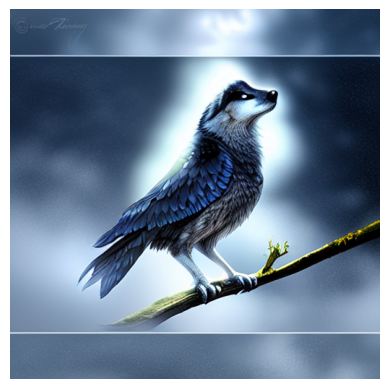

Generator(
  (latent_fc): Linear(in_features=128, out_features=16384, bias=True)
  (feature_fc): Linear(in_features=10, out_features=16384, bias=True)
  (main): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import cv2

# ============ 1️⃣ Load and Preprocess Image ============
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to fixed size
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_and_preprocess_image(image_path):
    """Load an image and extract edges using Canny."""
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))

    # Convert to grayscale and detect edges
    image_np = np.array(image)
    edges = cv2.Canny(image_np, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL format
    edge_image = Image.fromarray(edges)
    return image, edge_image

image_path = "/kaggle/input/bbbbbb/bird2.jpg"  # Change this to your image path
image_tensor = load_image(image_path)
input_image, control_image = load_and_preprocess_image(image_path)

# ============ 2️⃣ Define Generator with Feature Vector ============
class Generator(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, feature_dim=10):
        super(Generator, self).__init__()
        
        self.latent_fc = nn.Linear(latent_dim, 128 * 128)  # Latent vector to image size
        self.feature_fc = nn.Linear(feature_dim, 128 * 128)  # Feature vector processing
        
        self.main = nn.Sequential(
            nn.Conv2d(input_channels + 2, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x, latent_vector, feature_vector):
        latent_map = self.latent_fc(latent_vector).view(1, 1, 128, 128)
        feature_map = self.feature_fc(feature_vector).view(1, 1, 128, 128)
        
        # Concatenate input image, latent vector map, and feature map
        x = torch.cat((x, latent_map, feature_map), dim=1)
        return self.main(x)

# ============ 3️⃣ Define Discriminator ============
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# ============ 4️⃣ Training Loop with Stable Diffusion Image Generation ============
def train_singan_with_image_generation(image_tensor, num_epochs=10000, lr=0.0002):
    generator.train()
    discriminator.train()
    
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=3000, gamma=0.5)
    scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=3000, gamma=0.5)
    
    real_label = torch.ones(1, 1, 128, 128).to(device)
    fake_label = torch.zeros(1, 1, 128, 128).to(device)
    
    image_tensor = image_tensor.to(device)

    for epoch in range(num_epochs):
        # Generate random latent vector and feature vector
        latent_vector = torch.randn(1, 128).to(device)
        feature_vector = torch.randint(0, 2, (1, 10)).float().to(device)  # Random binary features
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        output_real = discriminator(image_tensor)
        loss_real = criterion(output_real, real_label)
        
        fake_image = generator(image_tensor, latent_vector, feature_vector)
        output_fake = discriminator(fake_image.detach())
        loss_fake = criterion(output_fake, fake_label)
        
        loss_d = (loss_real + loss_fake) / 2
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        output_fake = discriminator(fake_image)
        loss_g = criterion(output_fake, real_label)
        loss_g.backward()
        optimizer_g.step()

        scheduler_g.step()
        scheduler_d.step()

        # Generate and display an image only during the final epoch
        if epoch + 1 == num_epochs:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
            
            # Generate Modified Image using Stable Diffusion + ControlNet
            controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=torch.float16)
            pipe = StableDiffusionControlNetPipeline.from_pretrained(
                "runwayml/stable-diffusion-v1-5",
                controlnet=controlnet,
                torch_dtype=torch.float16
            )
            pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
            pipe.to(device)

            # Updated scary horror prompt
            prompt = "A  wolf bird, ultra-detailed, digital painting, cinematic depth, realistic textures, fantasy lighting, high-quality character portrait"
            negative_prompt = "blurry, low quality, bad anatomy, distorted face, extra limbs, unrealistic proportions"

            generated_image = pipe(
                prompt=prompt,
                image=control_image,  # Use edge-detected image as control input
                negative_prompt=negative_prompt,
                num_inference_steps=80,  # Increased steps for better quality
                guidance_scale=12,  # Stronger prompt adherence
                num_images_per_prompt=1  # Ensure only 1 image is generated
            ).images[0]

            # Display Generated Image
            plt.imshow(generated_image)
            plt.axis("off")  # Hide axes
            plt.show()

    return generator

# Start training the GAN and generate Stable Diffusion image only during the final epoch
train_singan_with_image_generation(image_tensor)


Epoch 1/1500 | D: 1.4063 | G: 0.6760
Epoch 100/1500 | D: 1.2247 | G: 0.8609 | P_obj: -0.6538
Epoch 200/1500 | D: 1.1849 | G: 0.9024
Epoch 300/1500 | D: 1.1663 | G: 0.8935
Epoch 400/1500 | D: 4.0114 | G: 0.2428
Epoch 500/1500 | D: 0.8348 | G: 1.3459 | P_obj: -0.5219
Epoch 600/1500 | D: 0.4664 | G: 1.3413
Epoch 700/1500 | D: 0.2724 | G: 2.2761
Epoch 800/1500 | D: 0.1534 | G: 2.8244
Epoch 900/1500 | D: 0.0800 | G: 3.4663
Epoch 1000/1500 | D: 0.0607 | G: 3.8414 | P_obj: -0.0324
Epoch 1100/1500 | D: 0.0313 | G: 4.4722
Epoch 1200/1500 | D: 0.0231 | G: 4.7641
Epoch 1300/1500 | D: 0.0179 | G: 5.0313
Epoch 1400/1500 | D: 0.0126 | G: 5.3584 | P_obj: -0.0060
Epoch 1500/1500 | D: 0.0121 | G: 6.1089


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

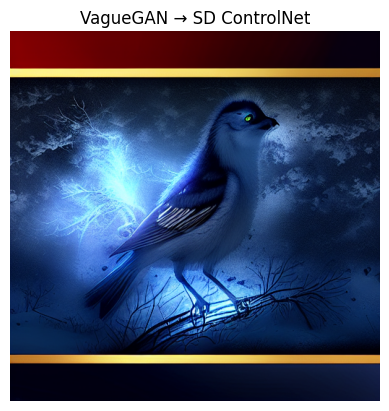


[Spectral Signature Report]
Samples: 1500 | Poison rate: 0.305
Precision: 0.307 | Recall: 0.101 | F1: 0.152

Backdoor Success (proxy intensity lift): 0.0000


In [8]:
# vaguegan_full_thesis.py
import os, random, numpy as np
from typing import Tuple, List
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import precision_recall_fscore_support

# ------------------------
# 1) Data loaders
# ------------------------
def load_image(image_path: str, size: Tuple[int,int]=(128,128)) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def load_softedge_control_image(image_path: str, size: Tuple[int,int]=(512,512)):
    image = Image.open(image_path).convert("RGB").resize(size)
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    edges = np.uint8(np.absolute(edges))
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edge_image = Image.fromarray(edges_rgb)
    return image, edge_image

# ------------------------
# 2) VagueGAN Poisoner
# ------------------------
class PoisonerNet(nn.Module):
    def __init__(self, in_channels=3, z_dim=32, hidden=64):
        super().__init__()
        self.z_proj = nn.Sequential(nn.Linear(z_dim,16*16), nn.ReLU(True))
        self.upsample = nn.Upsample(size=(128,128), mode='bilinear', align_corners=False)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels+1, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, hidden,3,1,1), nn.ReLU(True),
            nn.Conv2d(hidden, in_channels,3,1,1), nn.Tanh()
        )
    def forward(self,x,z):
        N,_,H,W = x.shape
        z_map = self.z_proj(z).view(N,1,16,16)
        z_map = self.upsample(z_map)
        return self.net(torch.cat([x,z_map],dim=1))

def project_linf(x, eps):
    return torch.clamp(x, -eps, eps)

def total_variation(x):
    return ((x[:,:,1:,:]-x[:,:,:-1,:]).abs().mean() +
            (x[:,:,:,1:]-x[:,:,:,:-1]).abs().mean())

def laplacian_abs_mean(x):
    kernel = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=x.dtype, device=x.device).view(1,1,3,3)
    x_gray = x.mean(dim=1,keepdim=True)
    lap = torch.nn.functional.conv2d(x_gray, kernel, padding=1)
    return lap.abs().mean()

# ------------------------
# 3) GAN Models
# ------------------------
class Generator(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128, feature_dim=10):
        super().__init__()
        self.latent_fc = nn.Linear(latent_dim, 128*128)
        self.feature_fc = nn.Linear(feature_dim, 128*128)
        self.main = nn.Sequential(
            nn.Conv2d(input_channels+2,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(True),
            nn.Conv2d(128,256,3,1,1), nn.ReLU(True),
            nn.Conv2d(256,128,3,1,1), nn.ReLU(True),
            nn.Conv2d(128,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,3,3,1,1), nn.Tanh()
        )
    def forward(self, x, latent_vector, feature_vector):
        N = x.size(0)
        latent_map = self.latent_fc(latent_vector).view(N,1,128,128)
        feature_map = self.feature_fc(feature_vector).view(N,1,128,128)
        x = torch.cat([x,latent_map,feature_map],dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self,input_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,64,3,1,1)
        self.act1 = nn.LeakyReLU(0.2,inplace=True)
        self.conv2 = nn.Conv2d(64,128,3,1,1)
        self.act2 = nn.LeakyReLU(0.2,inplace=True)
        self.conv3 = nn.Conv2d(128,1,3,1,1)
        self.out_act = nn.Sigmoid()
        self.gap = nn.AdaptiveAvgPool2d((1,1))
    def forward(self,x,return_features:bool=True):
        h = self.act1(self.conv1(x))
        h = self.act2(self.conv2(h))
        logits = self.conv3(h)
        out = self.out_act(logits)
        if return_features:
            feat = self.gap(h).view(x.size(0),-1)
            return out, feat
        return out

# ------------------------
# 4) Backdoor proxy
# ------------------------
@torch.no_grad()
def backdoor_success_proxy(G: nn.Module, base_input: torch.Tensor, eps: float, trials:int=5) -> float:
    device = next(G.parameters()).device
    base_input = base_input.to(device)
    diffs = []
    N,C,H,W = base_input.shape
    size = 10
    r0 = H-8-size; c0=W-8-size
    r_s = slice(max(r0,0), max(r0,0)+size)
    c_s = slice(max(c0,0), max(c0,0)+size)
    for _ in range(trials):
        z = torch.randn(N,128,device=device)
        f = torch.randint(0,2,(N,10),device=device,dtype=torch.float)
        y_clean = G(base_input,z,f).detach().cpu()
        x_trig = base_input.clone()
        x_trig[:,:,r_s,c_s] = torch.clamp(x_trig[:,:,r_s,c_s]+eps,-1,1)
        y_trig = G(x_trig,z,f).detach().cpu()
        rc = ((y_clean[:,:,r_s,c_s]+1)/2).mean().item()
        rt = ((y_trig[:,:,r_s,c_s]+1)/2).mean().item()
        diffs.append(rt-rc)
    return float(np.mean(diffs))

# ------------------------
# 5) Training loop
# ------------------------
def train_vaguegan(
    image_path: str,
    num_epochs: int = 1500,
    lr: float = 2e-4,
    poison_rate: float = 0.3,
    eps: float = 0.08,      # increased
    z_dim_poison: int = 32,
    lambda_stealth: float = 5e-2,
    lambda_tv: float = 1e-2,
    lambda_hf: float = 1e-2, # increased
    feature_collect_limit: int = 2000,
    print_every: int = 100,
    use_stable_diffusion: bool = True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G,D,P = Generator().to(device), Discriminator().to(device), PoisonerNet(z_dim=z_dim_poison).to(device)
    x0 = load_image(image_path).to(device)
    _, softedge_512 = load_softedge_control_image(image_path)
    criterion = nn.BCELoss()
    opt_g = optim.Adam(G.parameters(),lr=lr,betas=(0.5,0.999))
    opt_d = optim.Adam(D.parameters(),lr=lr,betas=(0.5,0.999))
    opt_p = optim.Adam(P.parameters(),lr=lr,betas=(0.5,0.999))
    real_label = torch.ones(1,1,128,128,device=device)
    fake_label = torch.zeros(1,1,128,128,device=device)
    feat_bank, poison_flags = [], []

    for epoch in range(1,num_epochs+1):
        use_poison = random.random()<poison_rate
        x_real = x0
        if use_poison:
            z_p = torch.randn(1,z_dim_poison,device=device)
            delta = project_linf(P(x0,z_p)*eps, eps)
            x_real = torch.clamp(x0+delta, -1,1)

        x_real_det = x_real.detach()
        # --- D update
        opt_d.zero_grad()
        out_real, feat_real = D(x_real,return_features=True)
        loss_real = criterion(out_real, real_label)
        if len(feat_bank)<feature_collect_limit:
            feat_bank.append(feat_real.detach().cpu().numpy().squeeze(0))
            poison_flags.append(1 if use_poison else 0)
        z = torch.randn(1,128,device=device)
        f = torch.randint(0,2,(1,10),device=device,dtype=torch.float)
        x_fake_d = G(x_real_det,z,f).detach()
        out_fake = D(x_fake_d,return_features=False)
        loss_fake = criterion(out_fake, fake_label)
        (0.5*(loss_real+loss_fake)).backward()
        opt_d.step()

        # --- G update
        opt_g.zero_grad()
        z2 = torch.randn(1,128,device=device)
        f2 = torch.randint(0,2,(1,10),device=device,dtype=torch.float)
        x_fake_g = G(x_real_det,z2,f2)
        out_fake_for_g = D(x_fake_g,return_features=False)
        loss_g = criterion(out_fake_for_g, real_label)
        loss_g.backward()
        opt_g.step()

        # --- Poisoner update
        if use_poison:
            opt_p.zero_grad()
            z_p = torch.randn(1,z_dim_poison,device=device)
            delta = project_linf(P(x0,z_p)*eps,eps)
            x_poison = torch.clamp(x0+delta,-1,1)
            out_real_p,_ = D(x_poison,return_features=True)
            mse_stealth = torch.mean((x_poison-x0)**2)
            tv = total_variation(delta)
            hf = laplacian_abs_mean(delta)
            poison_obj = (-criterion(out_real_p, real_label)
                          + lambda_stealth*mse_stealth
                          + lambda_tv*tv
                          - lambda_hf*hf)
            poison_obj.backward()
            opt_p.step()

        if epoch%print_every==0 or epoch==1:
            msg = f"Epoch {epoch}/{num_epochs} | D: {loss_real.item()+loss_fake.item():.4f} | G: {loss_g.item():.4f}"
            if use_poison:
                msg += f" | P_obj: {poison_obj.item():.4f}"
            print(msg)

        # --- Optional SD+ControlNet
        if epoch==num_epochs and use_stable_diffusion:
            try:
                from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
                controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=torch.float16)
                pipe = StableDiffusionControlNetPipeline.from_pretrained(
                    "runwayml/stable-diffusion-v1-5",
                    controlnet=controlnet,
                    torch_dtype=torch.float16
                )
                pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
                pipe.to(device)
                prompt = "A  wolf bird, ultra-detailed, digital painting, cinematic depth, realistic textures, fantasy lighting, high-quality character portrait"
                negative_prompt = "blurry, low quality, bad anatomy, distorted face, extra limbs, unrealistic proportions"
                gen_image = pipe(prompt=prompt, image=softedge_512, negative_prompt=negative_prompt,
                                num_inference_steps=60, guidance_scale=10, num_images_per_prompt=1).images[0]
                plt.imshow(gen_image); plt.axis("off"); plt.title("VagueGAN → SD ControlNet"); plt.show()
            except Exception as e:
                print(f"[WARN] Stable Diffusion skipped: {e}")

    # --- Spectral signature analysis
    F = np.vstack(feat_bank)
    y = np.array(poison_flags)
    F_center = F-F.mean(axis=0,keepdims=True)
    U,S,Vt = np.linalg.svd(F_center,full_matrices=False)
    v1 = Vt[0]
    scores = np.abs(F_center @ v1)
    thresh = np.percentile(scores,90.0)
    pred = (scores>=thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y,pred,average='binary',zero_division=0)
    print("\n[Spectral Signature Report]")
    print(f"Samples: {len(y)} | Poison rate: {y.mean():.3f}")
    print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    basr = backdoor_success_proxy(G,x0,eps=eps)
    print(f"\nBackdoor Success (proxy intensity lift): {basr:.4f}")

    return G,P

# ------------------------
# 6) Run
# ------------------------
if __name__=="__main__":
    IMAGE_PATH = "/kaggle/input/bbbbbb/bird2.jpg"
    G_model, P_model = train_vaguegan(
        image_path=IMAGE_PATH,
        num_epochs=1500,
        lr=2e-4,
        poison_rate=0.3,
        eps=0.08,
        lambda_hf=1e-2,
        feature_collect_limit=2000,
        print_every=100,
        use_stable_diffusion=True
    )
